In [1]:
cd ..

/home/luco/python/rnn


In [2]:
%matplotlib inline

# Time Series Modeling with Evolutionary Strategy

This notebook is highly experimental, I wanted to train some neural nets without backprop.

**Task:** Time Series Prediction

**Algorithm:** GRU recurrent neural network trained with evolutionary strategy

**Evaluation:** mean squared error, holdout, lots of visualizations

### The notebook contains two things:


 - minimalistic deep learning "library" implemeting GRU reccurrent layer
 - evolutionary strategy inspired by its recent success in reinforcement learning - https://blog.openai.com/evolution-strategies/


In [3]:
import numpy as np
import seaborn as sb

from copy import deepcopy
from scipy.special import expit as sigmoid
from pandas import read_csv
from matplotlib import pyplot

## Data

https://datamarket.com/data/set/22v9/monthly-closings-of-the-dow-jones-industrial-index-aug-1968-aug-1981#!ds=22v9&display=line

In [4]:
data = read_csv("data/monthly-sales-of-new-onefamily-h.csv", delimiter=";")

** Let's consider only the first 5 years (60 months) to speed up training **

In [45]:
vals_all = data["Monthly sales of new one-family houses sold in th e USA since 1973"].values
vals = np.array(vals_all[:60], dtype=np.float32)

** No preprocessing is used. **

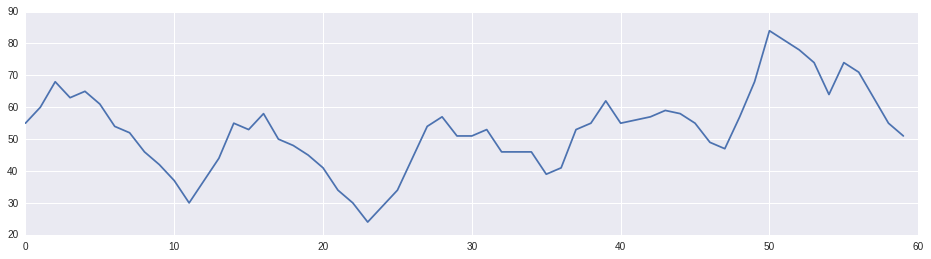

In [6]:
pyplot.subplots(figsize=(16,4))
pyplot.plot(vals)

We can see an apparent annual seasonality in the data - peaks during springs, craters during winters

# Micro Deep Learning Library

## Layers

In [7]:
class Layer(object):
    
    def __init__(self, parameters, input_shape, output_shape):
        
        self.parameters = parameters
        self.input_shape = input_shape
        self.output_shape = output_shape

    def reset(self):
        """
        Resets state vector in reccurrent layers.
        """
        pass

### Dense / ReLu

In [8]:
class ReLu(Layer):

    def __init__(self, x_size, y_size):
        
        self.W = np.random.randn(*(y_size, x_size))
        self.b = np.random.randn(*(y_size,))
        
        super(ReLu, self).__init__(
            [self.W, self.b],
            (x_size, ), (y_size, )
        )
    
    def __call__(self, x):
        return np.maximum(0, self.W.dot(x) + self.b)

### Reccurrent / GRU

In [9]:
class GRU(Layer):

    def __init__(self, x_size, s_size):
                
        self.Wz = np.random.randn(*(s_size, x_size))
        self.Wr = np.random.randn(*(s_size, x_size))
        self.Wh = np.random.randn(*(s_size, x_size))
        
        self.Uz = np.random.randn(*(s_size, s_size))
        self.Ur = np.random.randn(*(s_size, s_size))
        self.Uh = np.random.randn(*(s_size, s_size))
        
        self.bz = np.random.randn(*(s_size,))
        self.br = np.random.randn(*(s_size,))
        self.bh = np.random.randn(*(s_size,))
        
        self.initial_state = np.random.randn(*(s_size,))

        super(GRU, self).__init__(
            [self.Wz, self.Wr, self.Wh,
             self.Uz, self.Ur, self.Uh,
             self.bz, self.br, self.bh,
             self.initial_state],
            (x_size, ), (s_size, )
        )        
        
        self.s = None
        self.reset()
    
    def __call__(self, x):
        
        z = sigmoid(self.Wz.dot(x) + self.Uz.dot(self.s) + self.bz)
        r = sigmoid(self.Wr.dot(x) + self.Ur.dot(self.s) + self.br)
        self.s = z * self.s + (1 - z) * np.tanh(self.Wh.dot(x) + self.Uh.dot(r * self.s) + self.bh)

        return self.s
    
    def reset(self):
        
        self.s = deepcopy(self.initial_state)

## Model Class - Stack of Layers

In [10]:
class Model(object):

    def __init__(self, layers):
        
        self.layers = layers
        self.weights = None  # weight vector
        self.collect_weights()
    
    def __call__(self, x):
        """
        Computes y given x.
        """
        y = x
        for layer in self.layers:
            y = layer(y)
        return y
        
    def collect_weights(self):
        """
        Smashes all weights from all layers to a single vector.
        """
        nb_weights = sum(param.size
                         for layer in self.layers
                         for param in layer.parameters)
        
        self.weights = np.zeros((nb_weights))
        
        offset = 0
        
        for layer in self.layers:
            for p in layer.parameters:
                self.weights[offset:offset + p.size] = p.ravel()
                offset += p.size
    
    def update_weights(self):
        """
        Updates weights in all layers according to global weight vector.
        """
        offset = 0
        
        for layer in self.layers:
            for p in layer.parameters:
                p[:] = self.weights[offset:offset + p.size].reshape(p.shape)
                offset += p.size
        
        self.reset()
        
    def reset(self):
        """
        Resets states in all (reccurrent) layers.
        """
        for layer in self.layers:
            layer.reset()

# Our Model

3-layer reccurrent GRU followed by 2-layer dense ReLu

In [11]:
model = Model([
     GRU(3, 128),
     GRU(128, 64),
     GRU(64, 64),
     ReLu(64, 32),
     ReLu(32, 1)
])

In [19]:
def generate(n=1):
    """
    Generates time series from the initial date.
    """
    model.reset()

    for i in range(1, n):
        
        # If available, take the previous value from the dataset,
        # otherwise use `x` (the previous value generated by the model)
        prev_val = vals[i - 1] if i - 1 < len(vals) else x

        # The model has 3 inputs:
        x = np.array([
            i / 12,   # year
            i % 12,   # month
            prev_val  # previous value
        ])
        
        x = model(x)  
        yield x

In [31]:
def evaluate(m):
    """ Mean Squared Error """
    preds = np.concatenate(list(generate(len(vals))))
    return ((preds - vals[1:])**2).mean(axis=0)

## Evolutionary Strategy Algorithm

Taken from: https://blog.openai.com/evolution-strategies/

In [32]:
def train(npop=50, sigma=0.1, alpha=0.005, iters=50):

    # npop     population size  
    # sigma    noise standard deviation  
    # alpha    learning rate
    
    # Warning  not ready for interruption, it will leave the model with crappy weights

    for i in range(iters):

        w = deepcopy(model.weights)

        N = np.random.randn(npop, w.size)
        R = np.zeros(npop)

        for j in range(npop):

            w_try = w + sigma * N[j]
            model.weights = w_try
            model.update_weights()
            model.reset()
            R[j] = evaluate(model)

        A = (R - np.mean(R)) / np.std(R)

        model.weights = w - alpha / (npop * sigma) * np.dot(N.T, A)
        model.update_weights()
        model.reset()

        print "\rError: " + str(evaluate(model)),

## Training

We will watch the evolution of the function.

In [41]:
def show_graph():
    pyplot.subplots(figsize=(14,6))
    model.reset()
    ax = pyplot.subplot(111)
    pyplot.plot(vals[1:], label="original")
    pyplot.plot(np.concatenate(list(generate(2 * len(vals)))), label="predicted")
    ax.legend()

### Plot / Random Initialization

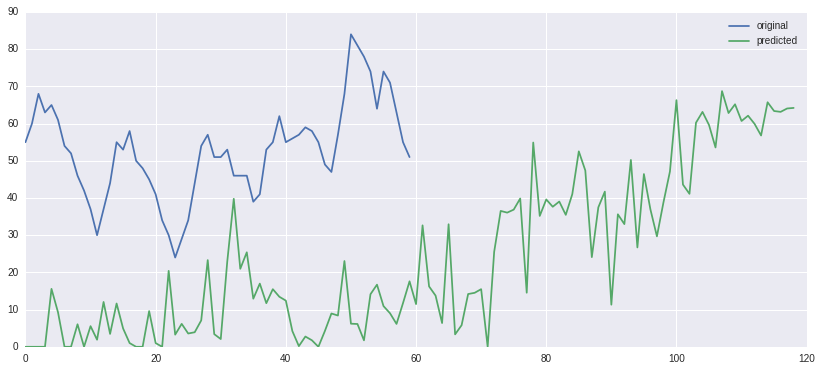

In [34]:
show_graph()

A mechanism could be implemented to automatically adjust `sigma` and `alpha` values.

For now, I just adjust them manually.

Error: 689.912965396                                                 


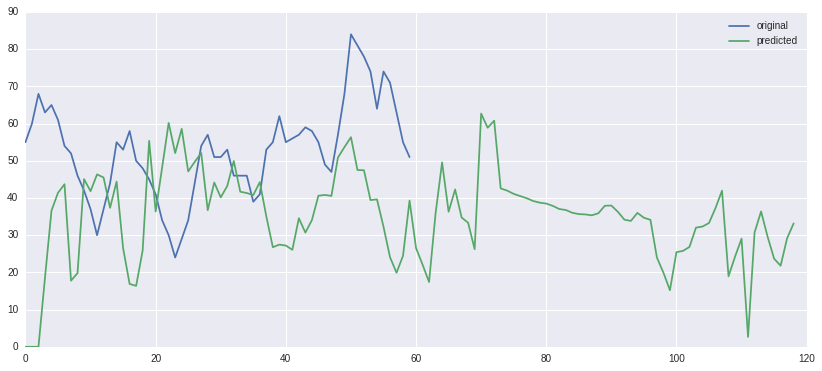

In [35]:
train(75, 0.25, 0.005, iters=50)
show_graph()

Error: 492.269976442                                                                                                   


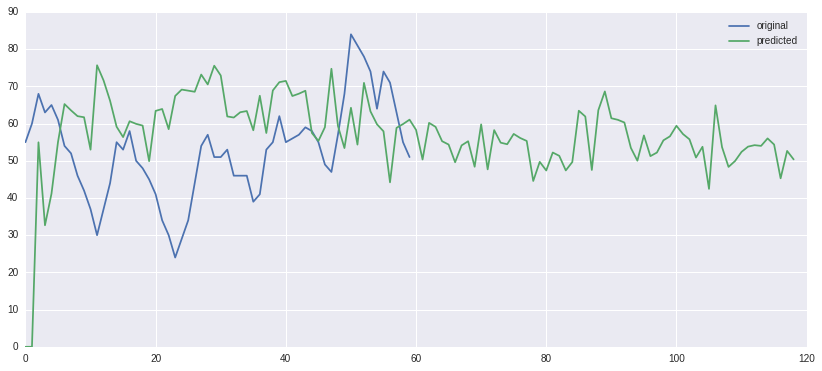

In [36]:
train(75, 0.15, 0.005, iters=50)
show_graph()

Error: 167.515872366                                                 


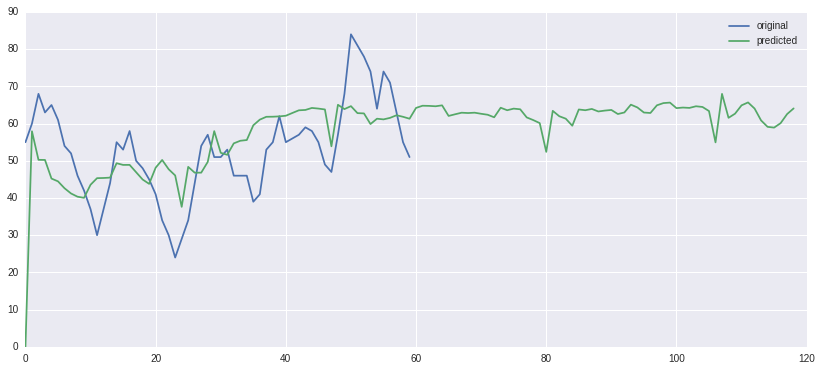

In [37]:
train(75, 0.05, 0.004, iters=50)
show_graph()

Error: 148.954684286                                                


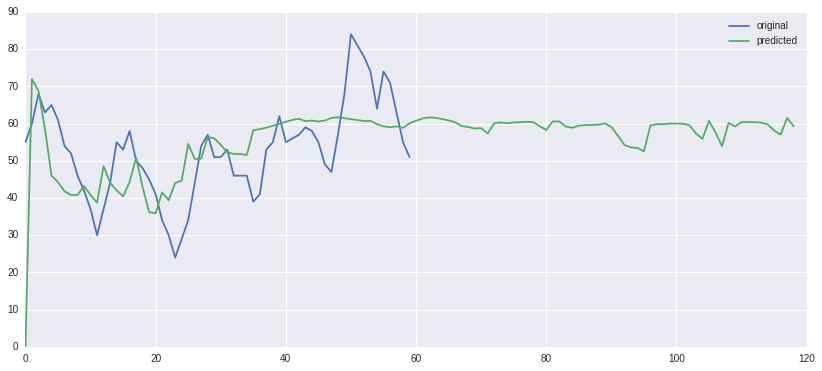

In [38]:
train(100, 0.05, 0.003, iters=50)
show_graph()

** Lowering the parameters finally brings something reasonable ** -- the model captures seasonality!

Error: 100.082503118                                                 


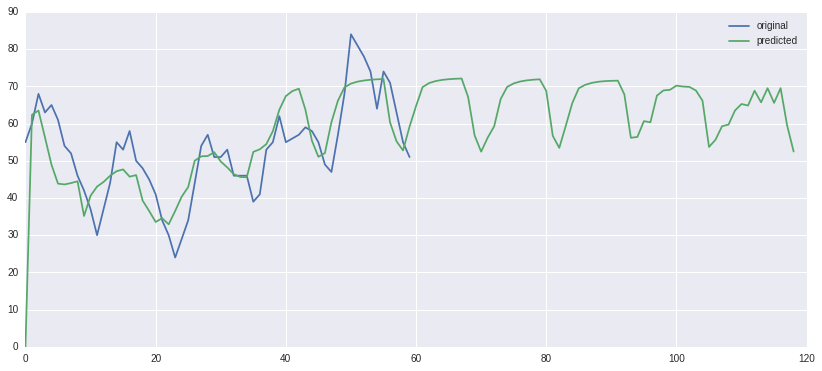

In [39]:
train(100, 0.02, 0.0015, iters=50)
show_graph()

Error: 84.9626310922                                                 


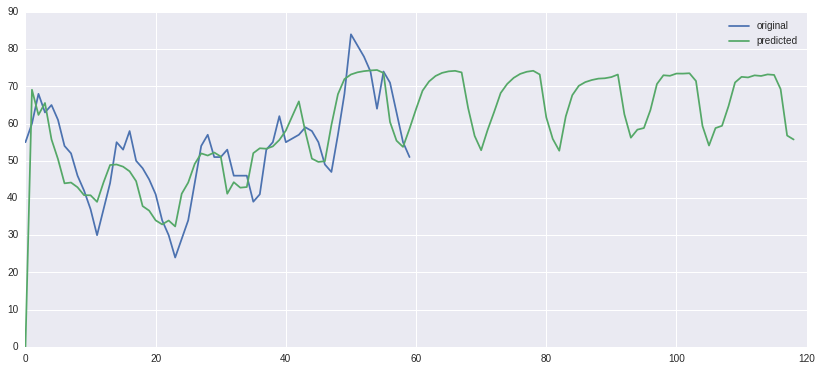

In [40]:
train(100, 0.01, 0.0005, iters=50)
show_graph()

Error: 79.7122466912                                                 


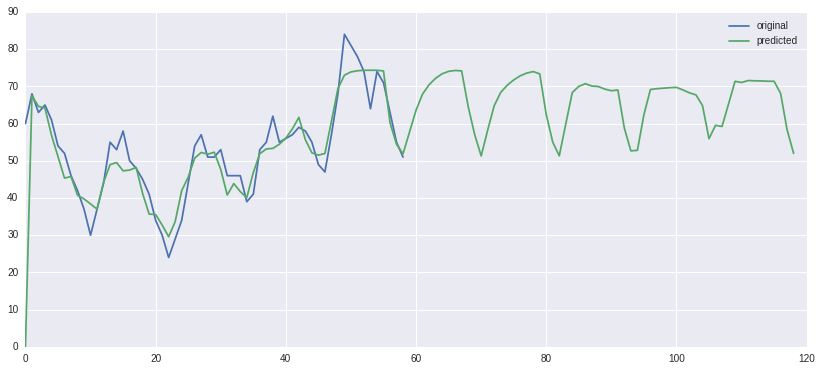

In [42]:
train(150, 0.0075, 0.00025, iters=50)
show_graph()

### Final Iterations

Error: 77.7052600554                                                 


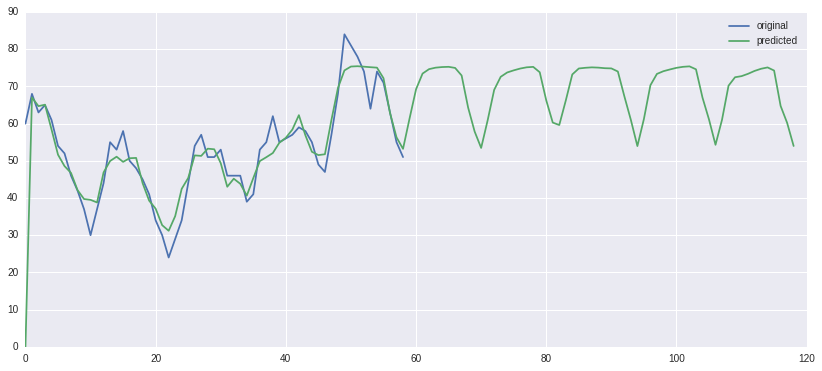

In [43]:
train(100, 0.0075, 0.00025, iters=50)
show_graph()

## Evaluation

### Graph for the Whole Dataset

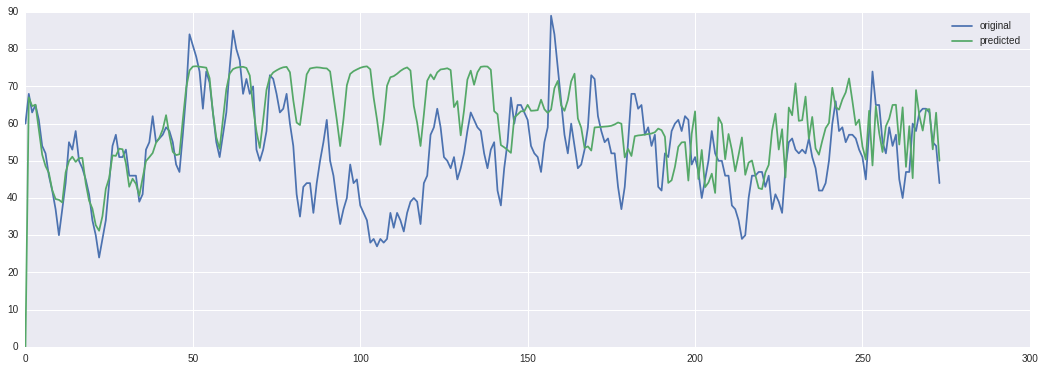

In [53]:
pyplot.subplots(figsize=(18,6))
model.reset()
ax = pyplot.subplot(111)
pyplot.plot(vals_all[1:], label="original")
pyplot.plot(np.concatenate(list(generate(len(vals_all - 1)))), label="predicted")
ax.legend()

Mean Squared Error on the rest of the dataset:

In [52]:
preds = np.concatenate(list(generate(len(vals_all))))[59:]
print ((preds - vals_all[60:])**2).mean(axis=0)

291.261079768


We can see that the nice annual seasonality eventually breaks after several years.  :(

## Conclusion

Neural nets can be trained without backprop.  It seems that the learned function captures annual seasonal variations for several future years.

It would be more interesting to train it on larger data (but also much slower - maybe mini-batching could be used to speed up the things).